In [80]:
from __future__ import absolute_import, division, print_function
from builtins import (
    ascii, bytes, chr, dict, filter, hex, input, int, map,
    next, oct, open, pow, range, round, str, super, zip)

import os
from itertools import cycle
from functools import partial
import random
from math import pi

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

# Imports for working with shapefiles
import pyproj
from shapely.geometry import shape, MultiPolygon, mapping
from shapely.ops import transform, cascaded_union
from descartes import PolygonPatch
import fiona
from fiona.crs import from_epsg

# matplotlib imports
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
from matplotlib.colors import to_rgb
from matplotlib import cm
from matplotlib.patches import Polygon
%matplotlib inline

In [10]:
wisc_census_blocks = 'data/block_groups/shapes/tl_2013_55_bg.shp'

In [11]:
project = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:4326'), 
    pyproj.Proj(init='epsg:3695')
)

In [124]:
poptot_df = pd.read_csv('data/block_groups/pop_tot/DEC_10_SF1_P1_with_ann.csv')
poptot_df = poptot_df[['GEO.id2', 'D001']]
poptot_df.columns = ['geoid', 'poptot']
poptot_df.drop(0, axis=0, inplace=True)
poptot_df.set_index('geoid', inplace=True)

In [116]:
pop18_df = pd.read_csv('data/block_groups/pop18/DEC_10_SF1_P10_with_ann.csv')
pop18_df = pop18_df[['GEO.id2', 'D001', 'D003']]
pop18_df.columns = ['geoid', 'pop18', 'pop18wht']
pop18_df.drop(0, axis=0, inplace=True)
pop18_df.set_index('geoid', inplace=True)

In [ ]:
with fiona.open(wisc_census_blocks) as f:
    blocks = [
        {
            'shape': transform(project, shape(block['geometry'])), 
            'geoid': block['properties']['GEOID']
        }
        for block in f
    ]

In [143]:
for block in blocks:
    block['centroid'] = np.array([coord[0] for coord in block['shape'].centroid.xy])
    block['pop18'] = int(pop18_df.loc[block['geoid']]['pop18'])
    block['pop18wht'] = int(pop18_df.loc[block['geoid']]['pop18wht'])
    block['poptot'] = int(poptot_df.loc[block['geoid']]['poptot'])

In [13]:
coord_array = np.array([block['centroid'] for block in blocks])

In [14]:
model = KMeans(n_clusters=8, max_iter=1e6, n_jobs=-1, tol=1e-11)

In [15]:
labels = model.fit_predict(coord_array)

In [134]:
for label, block in zip(labels, blocks):
    block['label'] = int(label)

In [145]:
districts = [{} for i in range(8)]
for label in range(8):
    districts[label]['shape'] = cascaded_union([block['shape'] for block in blocks if block['label'] == label])

In [152]:
ideal_dist_pop = np.sum([district['poptot'] for district in districts])/8

for label in range(8):
    _tot_pop = np.sum([block['poptot'] for block in blocks if block['label'] == label])
    districts[label]['poptot'] = _tot_pop
    
    _tot_pop18 = np.sum([block['pop18'] for block in blocks if block['label'] == label])
    districts[label]['pop18'] = _tot_pop18
    
    _tot_pop18wht = np.sum([block['pop18wht'] for block in blocks if block['label'] == label])
    districts[label]['pop18wht'] = _tot_pop18wht
    
    _area = districts[label]['shape'].area/(1000)**2
    _perimeter = districts[label]['shape'].length/1000
    districts[label]['compactness'] = (4*pi*_area/_perimeter**2)
    
    _pop_diff = _tot_pop - ideal_dist_pop
    districts[label]['signedvar'] = np.sign(_pop_diff)*(_pop_diff)**2
    
    

In [31]:
with fiona.open('data/districts/congressional/Wisconsin_Congressional_Districts.shp') as f:
    wisconsin = cascaded_union([transform(project, shape(district['geometry'])) for district in f])

In [159]:
def generate_colors(values, cmap, reference=1):
    _colors = [cmap(value/reference) for value in values]
    
    return _colors

In [170]:
def plot_shapes(shapelist, shape_colors):
    _patches = [
        PolygonPatch(shape['shape'].intersection(wisconsin))
        for shape in shapelist
    ]
    
    for patch, color in zip(_patches, cycle(shape_colors)):
        patch.set_facecolor(color)
        patch.set_linewidth(1.5)
        patch.set_alpha(0.85)
        
    fig, ax = plt.subplots()

    for patch in _patches:
        ax.add_patch(patch)

    ax.relim()
    ax.autoscale_view()
    ax.axis('off')
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    aspect_ratio = (ymax - ymin)/(xmax - xmin)
    x_size = 20
    fig.set_size_inches((x_size, x_size*aspect_ratio))

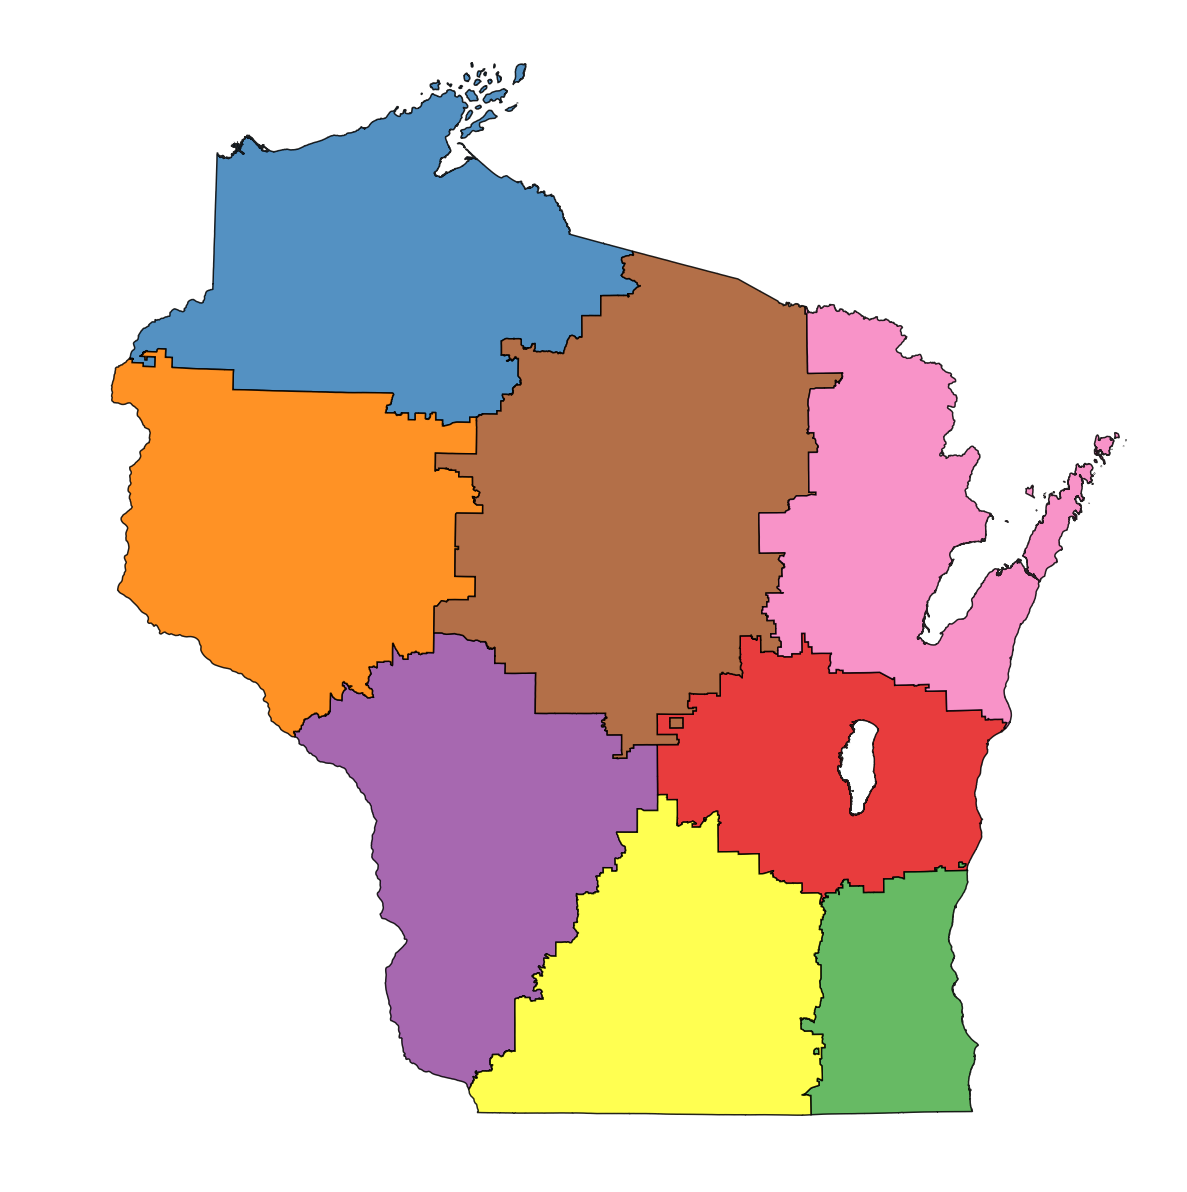

In [171]:
hex_colors = [
    '#e41a1c', '#377eb8', '#4daf4a', '#984ea3',
    '#ff7f00', '#ffff33', '#a65628', '#f781bf'
]
district_colors = [to_rgb(color) for color in hex_colors]

plot_shapes(districts, district_colors)

In [46]:
fig.savefig('images/naive_kmeans_districts.png', bbox_inches='tight')

In [60]:
project_back = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:3695'), 
    pyproj.Proj(init='epsg:4326')
)

In [157]:
schema = {
    'geometry': 'Polygon',
    'properties': {
        'id': 'int', 'cmpctness': 'float', 'poptot': 'int',
        'pop18': 'int', 'pop18wht': 'int', 'signedvar': 'float'
    }
}
with fiona.open('data/districts/generated/kmeans', 'w', 'ESRI Shapefile', schema) as c:
    for i, district in enumerate(districts):
            c.write({
                'geometry': mapping(district['shape']),
                'properties': {
                    'id': i+1, 
                    'cmpctness': district['compactness'],
                    'poptot': district['poptot'],
                    'pop18': district['pop18'],
                    'pop18wht': district['pop18wht'],
                    'signedvar': district['signedvar']
                }
            })

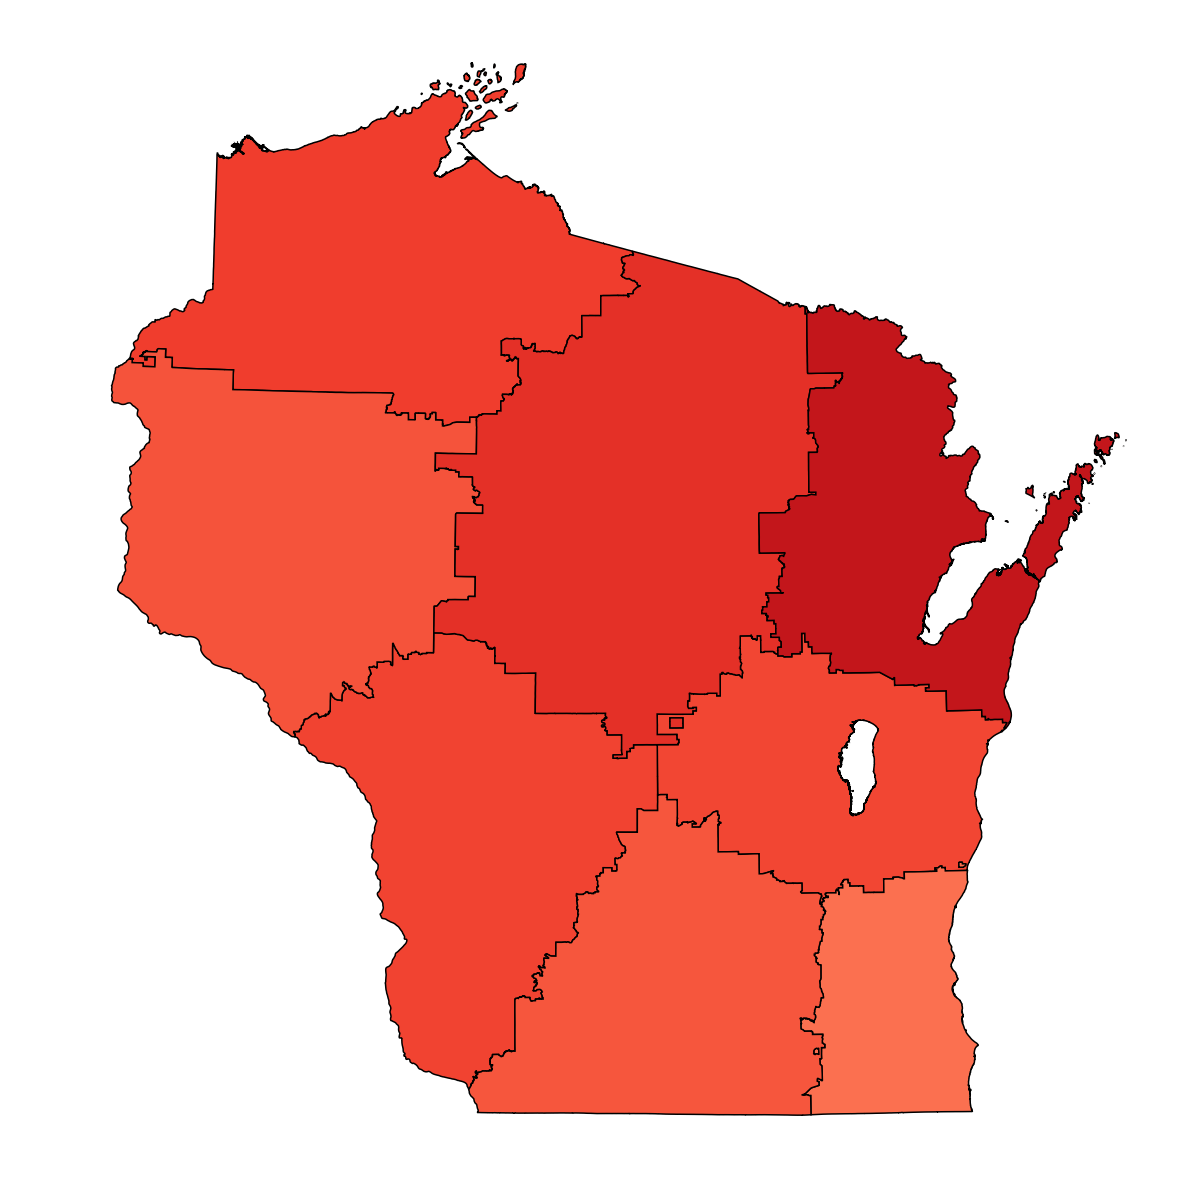

In [69]:
congressional_patches = [
    PolygonPatch(dis['shape'].intersection(wisconsin))
    for dis in districts
]

ref_aspect = 1.5
reference = 4*pi*(ref_aspect)/(2*(1+ref_aspect))**2
scale = cm.Reds_r
colors = [
    scale(dis['compactness']/reference)
    for dis in districts
]
for patch, color in zip(congressional_patches, cycle(colors)):
    patch.set_facecolor(color)
    patch.set_linewidth(1.5)

fig, ax = plt.subplots(figsize=(20,20))

for patch in congressional_patches:
    ax.add_patch(patch)
    
ax.relim()
ax.autoscale_view()
ax.axis('off')
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
aspect_ratio = (ymax - ymin)/(xmax - xmin)
x_size = 20
fig.set_size_inches((x_size, x_size*aspect_ratio))

In [78]:
district1 = districts[0]['shape']
district3 = districts[2]['shape']

In [79]:
district1.touches(district3)

True